In [122]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from textblob import TextBlob
import tweepy
import json
from gensim import corpora
import pickle
import gensim
import pandas as pd
import numpy as np
import pyLDAvis.gensim
import pyLDAvis
from nltk.tokenize import blankline_tokenize
import re
from nltk.corpus import stopwords
sw = set(stopwords.words('english')) 

%matplotlib inline

In [ ]:
handel = "Twitterhandel"

In [39]:
access_token = '4280334093-chPvXhzbR8iqfg6OgmBC7VCh2CXI7OjbXpLOSTOT'
access_token_secret = '5Y2rLLV3KbSLXXOBdfgrZKWcfxWVMWZ1WRAC0PqlxGIwmr'
consumer_key = 'zAeSYHQmFkdrV8KVm93gdfgnl1'
consumer_secret = '830lOjbynz80DuRwqXdfghdAANk5JxSrss09x5PTIYjGoHmxx98p'

In [41]:
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print('#',end='')
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
        #save most recent tweets
        alltweets.extend(new_tweets)
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

    return alltweets

In [ ]:
#pass in the username of the account you want to download
data = get_all_tweets(handel)

In [ ]:
alist = []
for i in data:
    d = json.dumps(i._json)
    alist.append(pd.DataFrame(json.loads(d)))

In [ ]:
all_data = pd.concat(alist)

In [ ]:
data.to_csv('data.csv')

In [88]:
#selecting the columns  
data = data[['created_at','favorite_count','retweet_count','text','lang']]

In [89]:
#parsing the data col
data.created_at = pd.to_datetime(data.created_at)

/home/data-sci/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [46]:
#selecting only the english tweets
all_data = data

In [90]:
data = data[data.lang == 'en']

In [108]:
data = data.drop_duplicates()

In [92]:
#set the date as the index
data.set_index('created_at', inplace=True)

In [94]:
def clean_text(r):
    t = r.lower()
    for i in list('@*/-+*&%\|$#!'):
        t = t.replace(i,'')
    return t.strip()

data.loc[:,'text'] = data.text.apply(clean_text)

In [174]:
def pol(r):
    """calculates the polarity of an input tweet the score from -1 to 1"""
    t = TextBlob(r)
    return t.polarity

def subj(r):
    """calculates the subjectivity of an input tweet the score from 0 to 1"""
    t = TextBlob(r)
    return t.subjectivity

def sw_remove(r):
    list_of_words = [i for i in wordpunct_tokenize(
    re.sub(r'\d+|[^\w\s]', '', (r.lower()))) if i not in sw ]
    return ' '.join(map(lambda x: '%s' % x, list_of_words))

In [175]:
data['sw_removed'] = data.text.apply(sw_remove)    

data['polar'] = data.text.apply(pol)
data['subj'] = data.text.apply(subj)

/home/data-sci/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## the sentmient for every tweet 

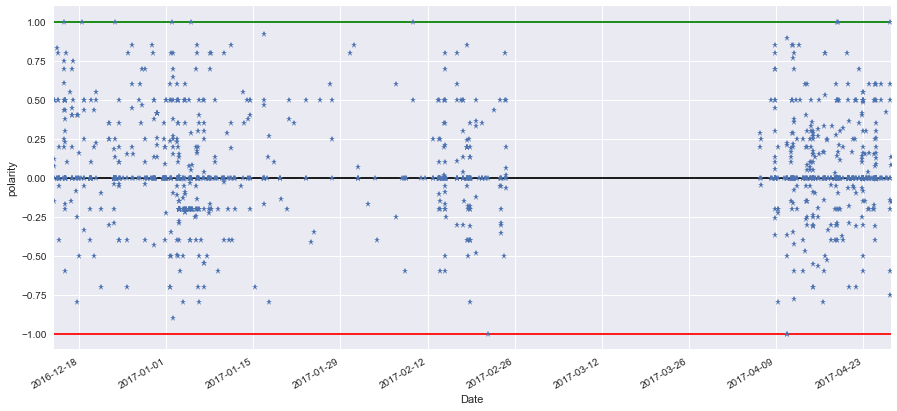

In [278]:
plt.figure(figsize=(15,7))
data.polar.plot(style='*')
plt.xlabel('Date')
plt.ylabel('polarity')
plt.hlines(0,data.index[0],data.index[-1])
plt.hlines(1,data.index[0],data.index[-1],colors='g')
plt.hlines(-1,data.index[0],data.index[-1],colors='r');

## Subjectivity scale for every tweet

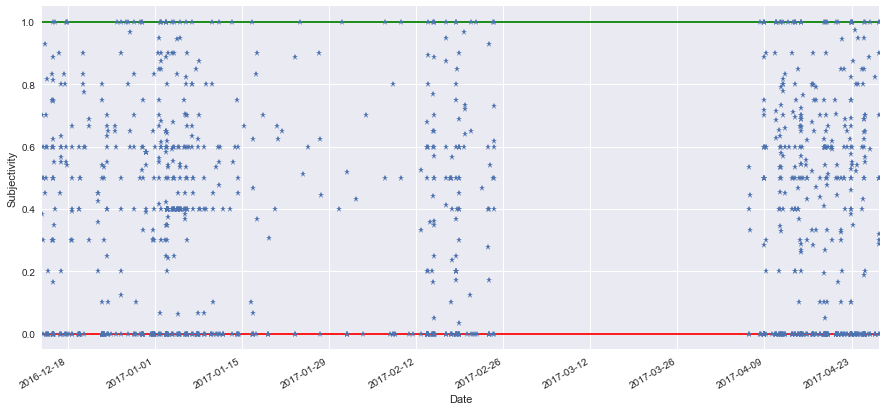

In [280]:
plt.figure(figsize=(15,7))
data.subj.plot(style='*')
plt.xlabel('Date')
plt.ylabel('Subjectivity')
plt.hlines(1,data.index[0],data.index[-1],colors='g')
plt.hlines(0,data.index[0],data.index[-1],colors='r');

In [203]:
class LDA():
    """
    this cless makes, saves to desk, and loads
        1- gensim dictionary
        2- corpus
        3- gensim lda model
    Args:
        data -> pandas series of type object (containing text) (optional)
        dictionary -> gensim.corpora.dictionary
        corpus-> gensim corpus (optional)
        model-> gensim lda model (optional)
        text_data= pandas cleaned text (optional)
        vis= pyLDAvis.display objec (optional)
    """

    def __init__(self,data):
        self.data = data
#         self.model = None
#         self.corpus = None
#         self.dictionary = None
#         self.text_data = None
#         self.vis = None

    "________________________DICTIONARY______________________"

    def make_dict(self):
        """takes pandas series and returns dictionary to use with gensim   """
        text_data = self.data.apply(lambda i: str(i).split(' '))
        dictionary = corpora.Dictionary(text_data)
        self.dictionary = dictionary
        self.text_data = text_data

    def save_dict(self, dict_name='dict'):
        """saves the dictionary to the disk
            dict_name --> dictionary path + filename
        """
        self.dictionary.save('{}.gensim'.format(dict_name))

    def load_dict(self, dict_name):
        dictionary = gensim.corpora.Dictionary.load('{}.gensim'.format(dict_name))
        self.dictionary = dictionary

    "________________________CORPUS___________________________"

    def make_corpus(self):
        """ makes a corpus from gensim.corpora.dictionary object """
        corpus = [self.dictionary.doc2bow(text) for text in self.text_data]
        self.corpus = corpus

    def save_corpus(self, corpus_name='corpus'):
        self.corpus.dump(self.corpus, open("{}.pkl".format(corpus_name), "wb"))

    def load_corpus(corpus_name='corpus'):
        self.corpus = pickle.load(open("{}.pkl".format(corpus_name), "rb"))

    "________________________MODEL____________________________"

    def make_model(self, num_top=4):
        self.model = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=num_top,
                                                     id2word=self.dictionary, passes=15)

    def save_model(self, model_name='model'):
        self.model.save('{}.gensim'.format(model_name))

    def load_model(self, model_name='model'):
        self.model = gensim.models.ldamodel.LdaModel.load('{}.gensim'.format(model_name))

    "________________________VIS_____________________________"

    def make_vis(self, sort_topics=True):
        lda_display = pyLDAvis.gensim.prepare(
            self.model, self.corpus, self.dictionary, sort_topics=sort_topics)
        self.vis = pyLDAvis.display(lda_display)

In [204]:
lda_data = data.sw_removed

In [205]:
lda_data = LDA(data=lda_data)

In [206]:
#making dicts
lda_data.make_dict()

In [207]:
#making corpuses 
lda_data.make_corpus()

In [208]:
#LDA model for the requirements data with 10 number of topics  
lda_data.make_model(num_top=4)

In [209]:
#LDA model for the description data with 10 number of topics  
lda_data.make_model()

In [210]:
#making lda visualization
lda_data.make_vis()

every topic represented as a circle, the distance between circles represent how similar or dissimilar they are based on the frequency of 
word occurrences, 
the red bar represent the frequency of the word occurring given a specific topic. 
the gray bar represents the frequency of a word overall. 
changing λ allows for control over how relevant terms for this specific topic

In [211]:
lda_data.vis

In [214]:
data['n'] = 1

/home/data-sci/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


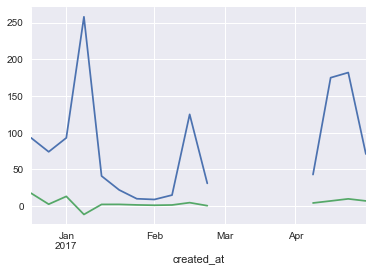

In [221]:
data.n.resample('w').sum().plot()
data.polar.resample('w').sum().plot()

### aggregation over the activity per day

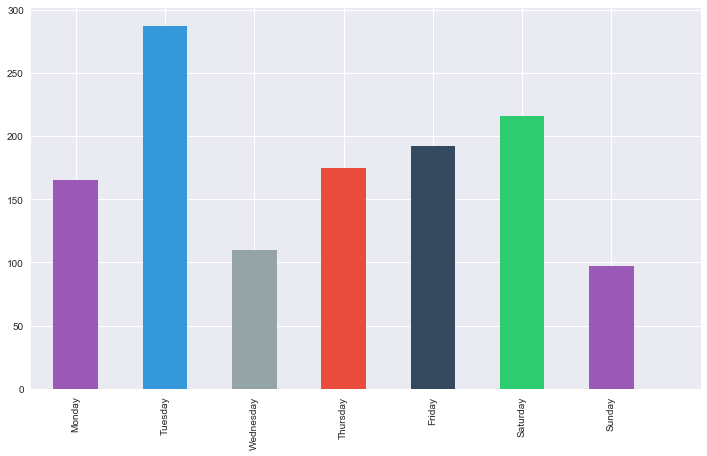

In [247]:
f = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
days = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
data.n.groupby(data.index.dayofweek).sum().plot(kind='bar',color=f,figsize=(12,7))
plt.xticks(np.arange(8),days);

### aggregation over the activity per hour

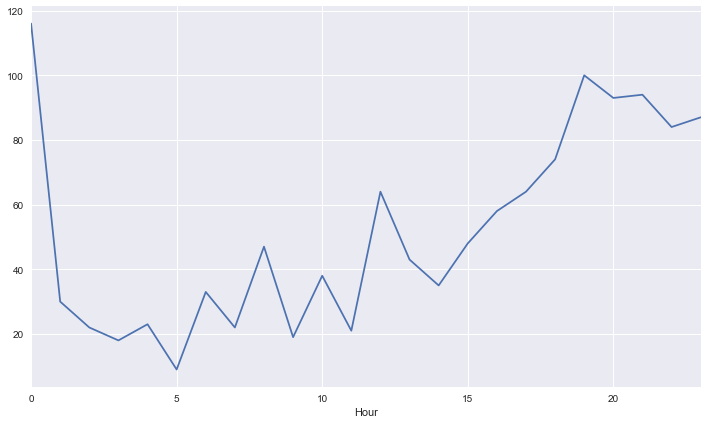

In [273]:
data.n.groupby(data.index.hour).sum().plot(figsize=(12,7))
plt.xlabel('Hour');

## sentiment 

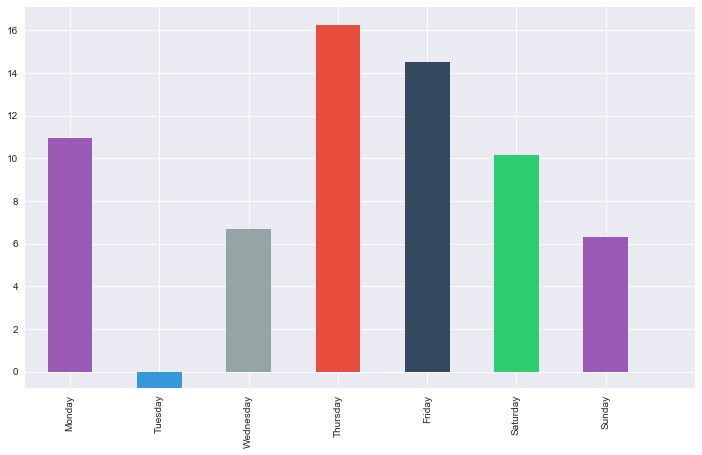

In [253]:
data.groupby(data.index.dayofweek)['polar'].sum().plot(kind='bar' ,figsize=(12,7),color=f)
plt.xticks(np.arange(8),days);

## sentiment over time 

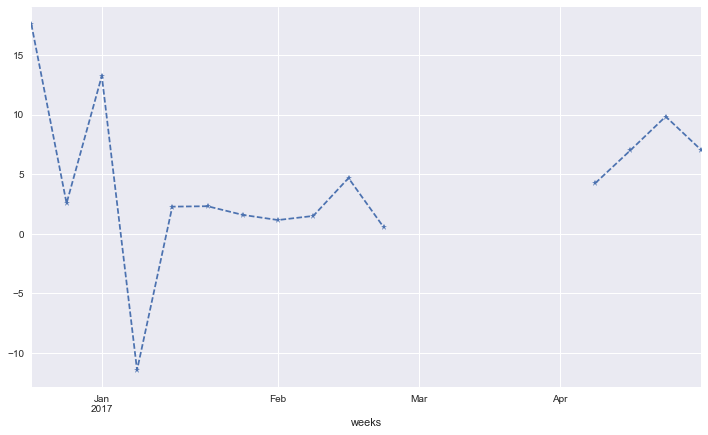

In [259]:
data.resample('w')['polar'].sum().plot(marker='*',linestyle='dashed',figsize=(12,7))
plt.xlabel('weeks');

### very negative sentiment

In [265]:
sum(data.polar < -0.5)

40

### very positive sentiment

In [266]:
data data.polar > 0.5

82

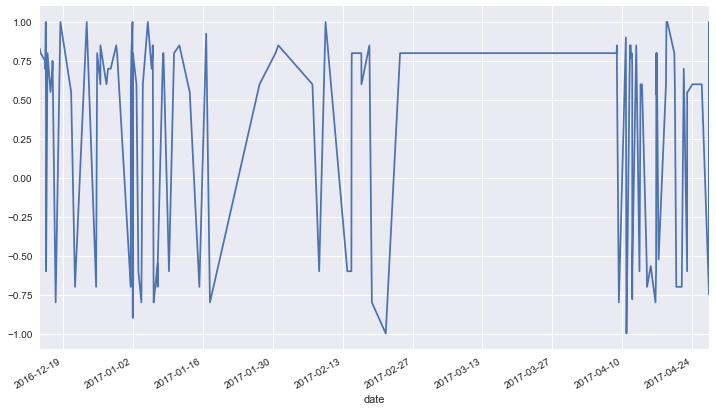

In [272]:
data[(data.polar > 0.5) | (data.polar < -0.5)]['polar'].plot(figsize=(12,7))
plt.xlabel('date');